In [1]:
import os

# this stops jax from stealing all the memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import jax
jax.config.update("jax_default_device", jax.devices("cpu")[0])

import svgutils.compose as svg
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from glob import glob
from orbax.checkpoint import (CheckpointManager,
                              PyTreeCheckpointer)

from projectlib.data import load_dataset

sns.set_theme(context="paper",
              font_scale=1.25,
              style="ticks",
              palette="colorblind")

2024-04-14 10:43:14.835258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reservoir results

In [2]:
# ckpt_path = "outputs/train-reservoir/2024-01-18/21-56-07/checkpoints/"
# ckpt_path = "outputs/train-reservoir/2024-01-18/22-42-35/checkpoints/"
ckpt_path = "outputs/train-reservoir/2024-04-14/10-41-48/checkpoints"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
ckpt = mgr.restore(mgr.latest_step())

In [3]:
targets = jnp.concatenate([jnp.reshape(x, (-1, x.shape[-1]))
                           for x in ckpt["metrics_history"]["train"]["target"]], axis=0)
outputs = jnp.concatenate([jnp.reshape(x, (-1, x.shape[-1]))
                           for x in ckpt["metrics_history"]["train"]["output"]], axis=0)

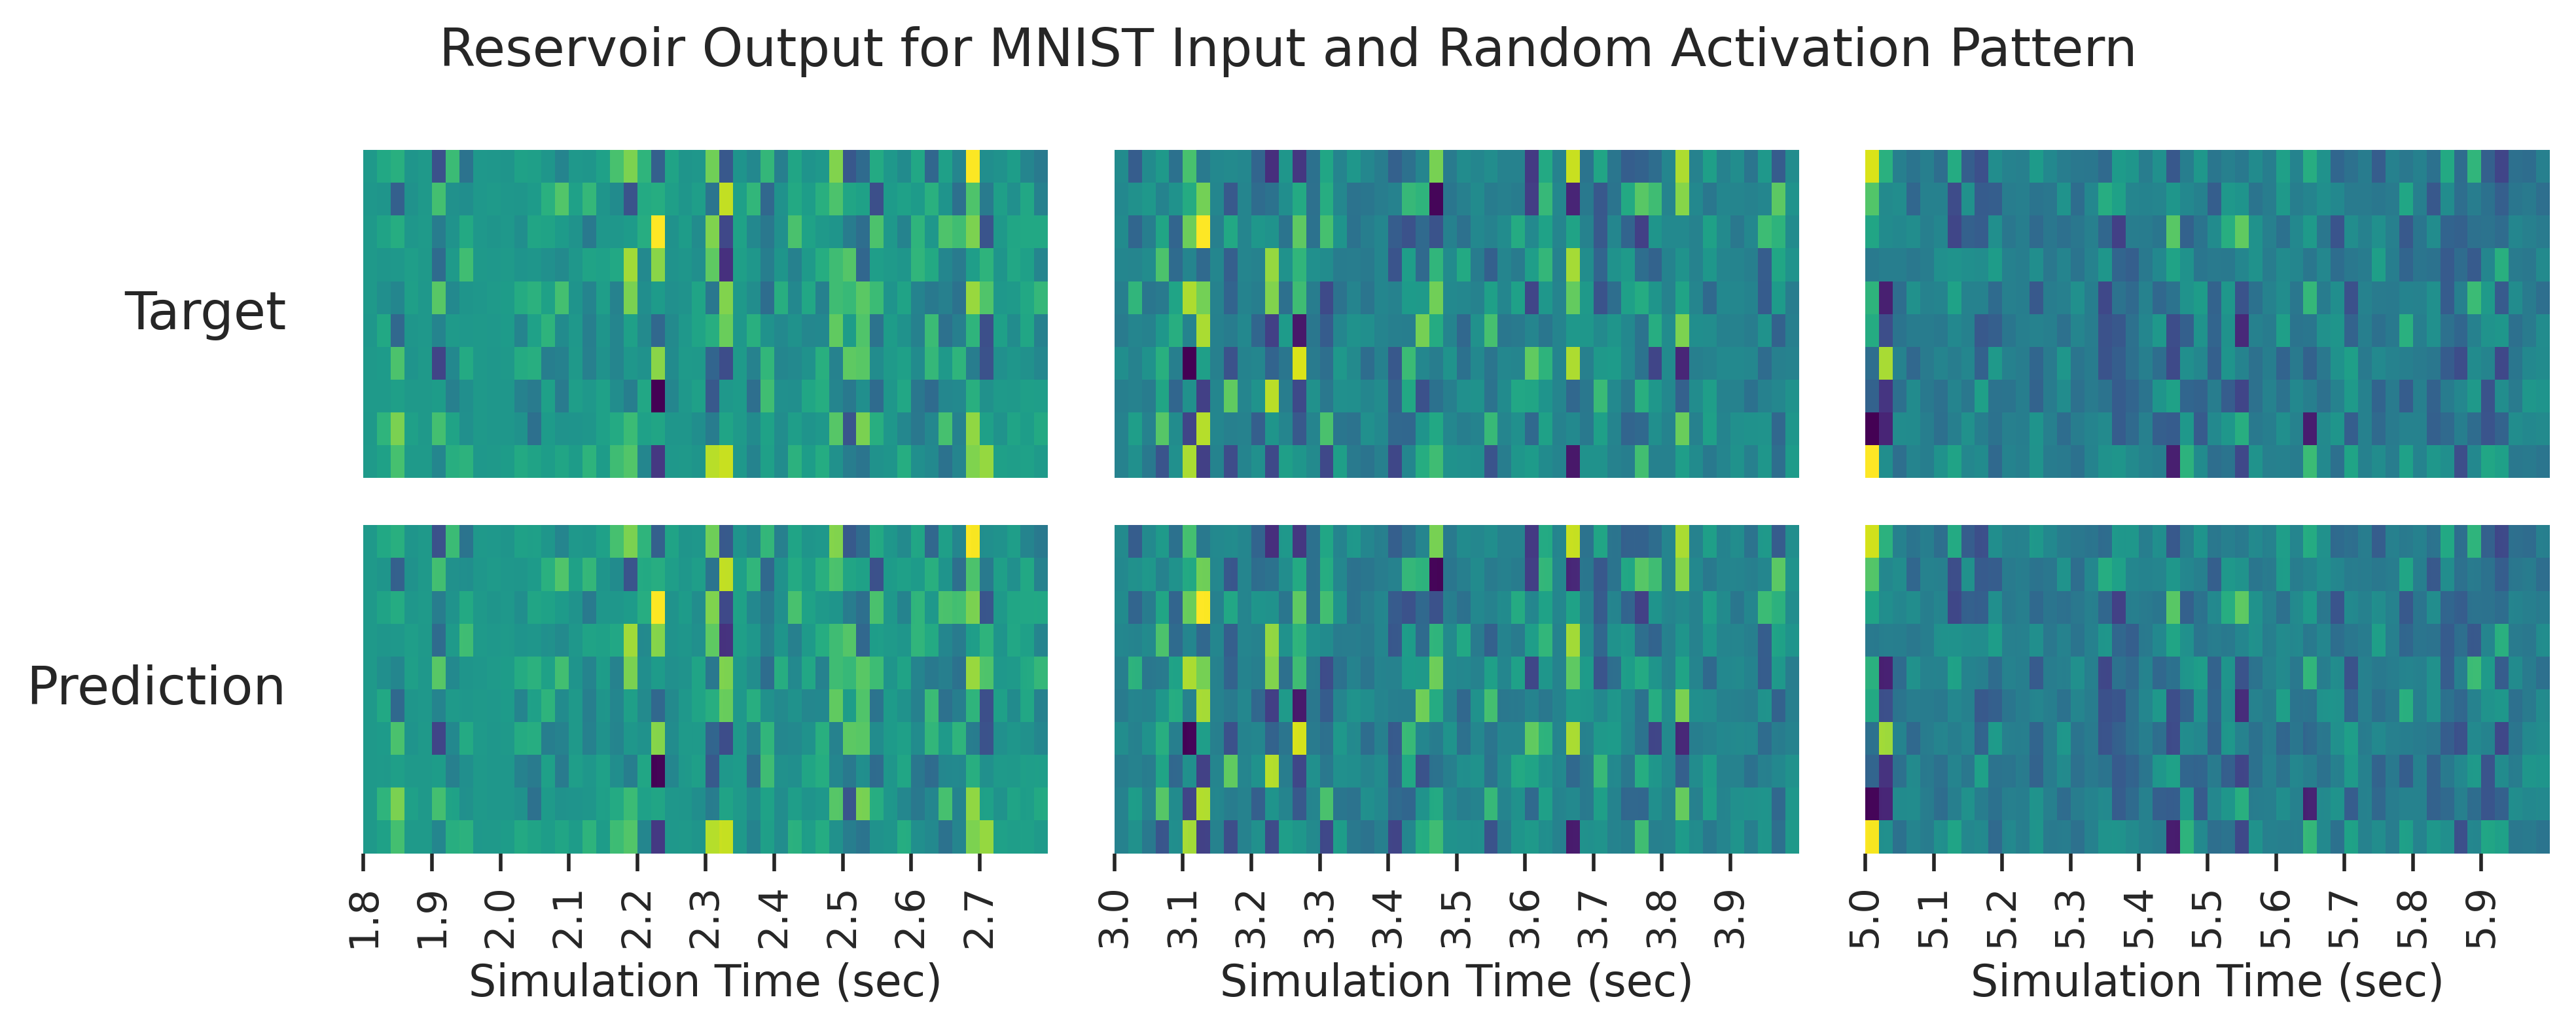

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, dpi=400, figsize=(10, 4),
                        subplot_kw={"sharex": True, "sharey": True})

t = jnp.arange(targets.shape[0]) * 1e-3
for i, (tmin, tmax) in enumerate([(1800, 2800), (3000, 4000), (5000, 6000)]):
    sns.heatmap(jnp.transpose(targets[tmin:tmax]),
                cbar=False, cmap="viridis", ax=axs[0, i])
    axs[0, i].set_xticklabels([])
    axs[0, i].set_yticklabels([])
    axs[0, i].tick_params(left=False, bottom=False)
    sns.heatmap(jnp.transpose(outputs[tmin:tmax]),
                cbar=False, cmap="viridis", ax=axs[1, i])
    axs[1, i].set_yticklabels([])
    axs[1, i].tick_params(left=False)
    axs[1, i].set_xticks(jnp.arange(0, tmax - tmin, 100),
                    map(lambda x: ("%.1f" % x), t[tmin:tmax:100]))
    axs[1, i].set_xlabel("Simulation Time (sec)")
axs[0, 0].annotate("Target",
                    xy=(0, 0.5),
                    xytext=(-axs[0, 0].yaxis.labelpad - 5, 0),
                    xycoords=axs[0, 0].yaxis.label,
                    textcoords='offset points',
                    size="large",
                    ha='right',
                    va='center')
axs[1, 0].annotate("Prediction",
                    xy=(0, 0.5),
                    xytext=(-axs[1, 0].yaxis.labelpad - 5, 0),
                    xycoords=axs[1, 0].yaxis.label,
                    textcoords='offset points',
                    size="large",
                    ha='right',
                    va='center')
fig.suptitle("Reservoir Output for MNIST Input and Random Activation Pattern")
fig.tight_layout()
fig.savefig("reservoir-output.pdf")

# Small experiment results

In [2]:
ckpt_path = "outputs/train-lif-biohsic/linear-results-2/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
linear_ckpt = mgr.restore(mgr.latest_step())

ckpt_path = "outputs/train-lif-biohsic/xor-results-2/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
xor_ckpt = mgr.restore(mgr.latest_step())

In [3]:
linear_data = load_dataset("linear")["train"]
xor_data = load_dataset("xor")["train"]

In [4]:
linear_acc = jnp.stack(linear_ckpt["metrics_history"]["test"]["accuracy"]) * 100
xor_acc = jnp.stack(xor_ckpt["metrics_history"]["test"]["accuracy"]) * 100
linear_hsic = jnp.stack([jnp.stack(linear_ckpt["metrics_history"]["train"][f"hsic_layer{i}"])
                         for i in range(2)], axis=-1)
xor_hsic = jnp.stack([jnp.stack(xor_ckpt["metrics_history"]["train"][f"hsic_layer{i}"])
                      for i in range(3)], axis=-1)

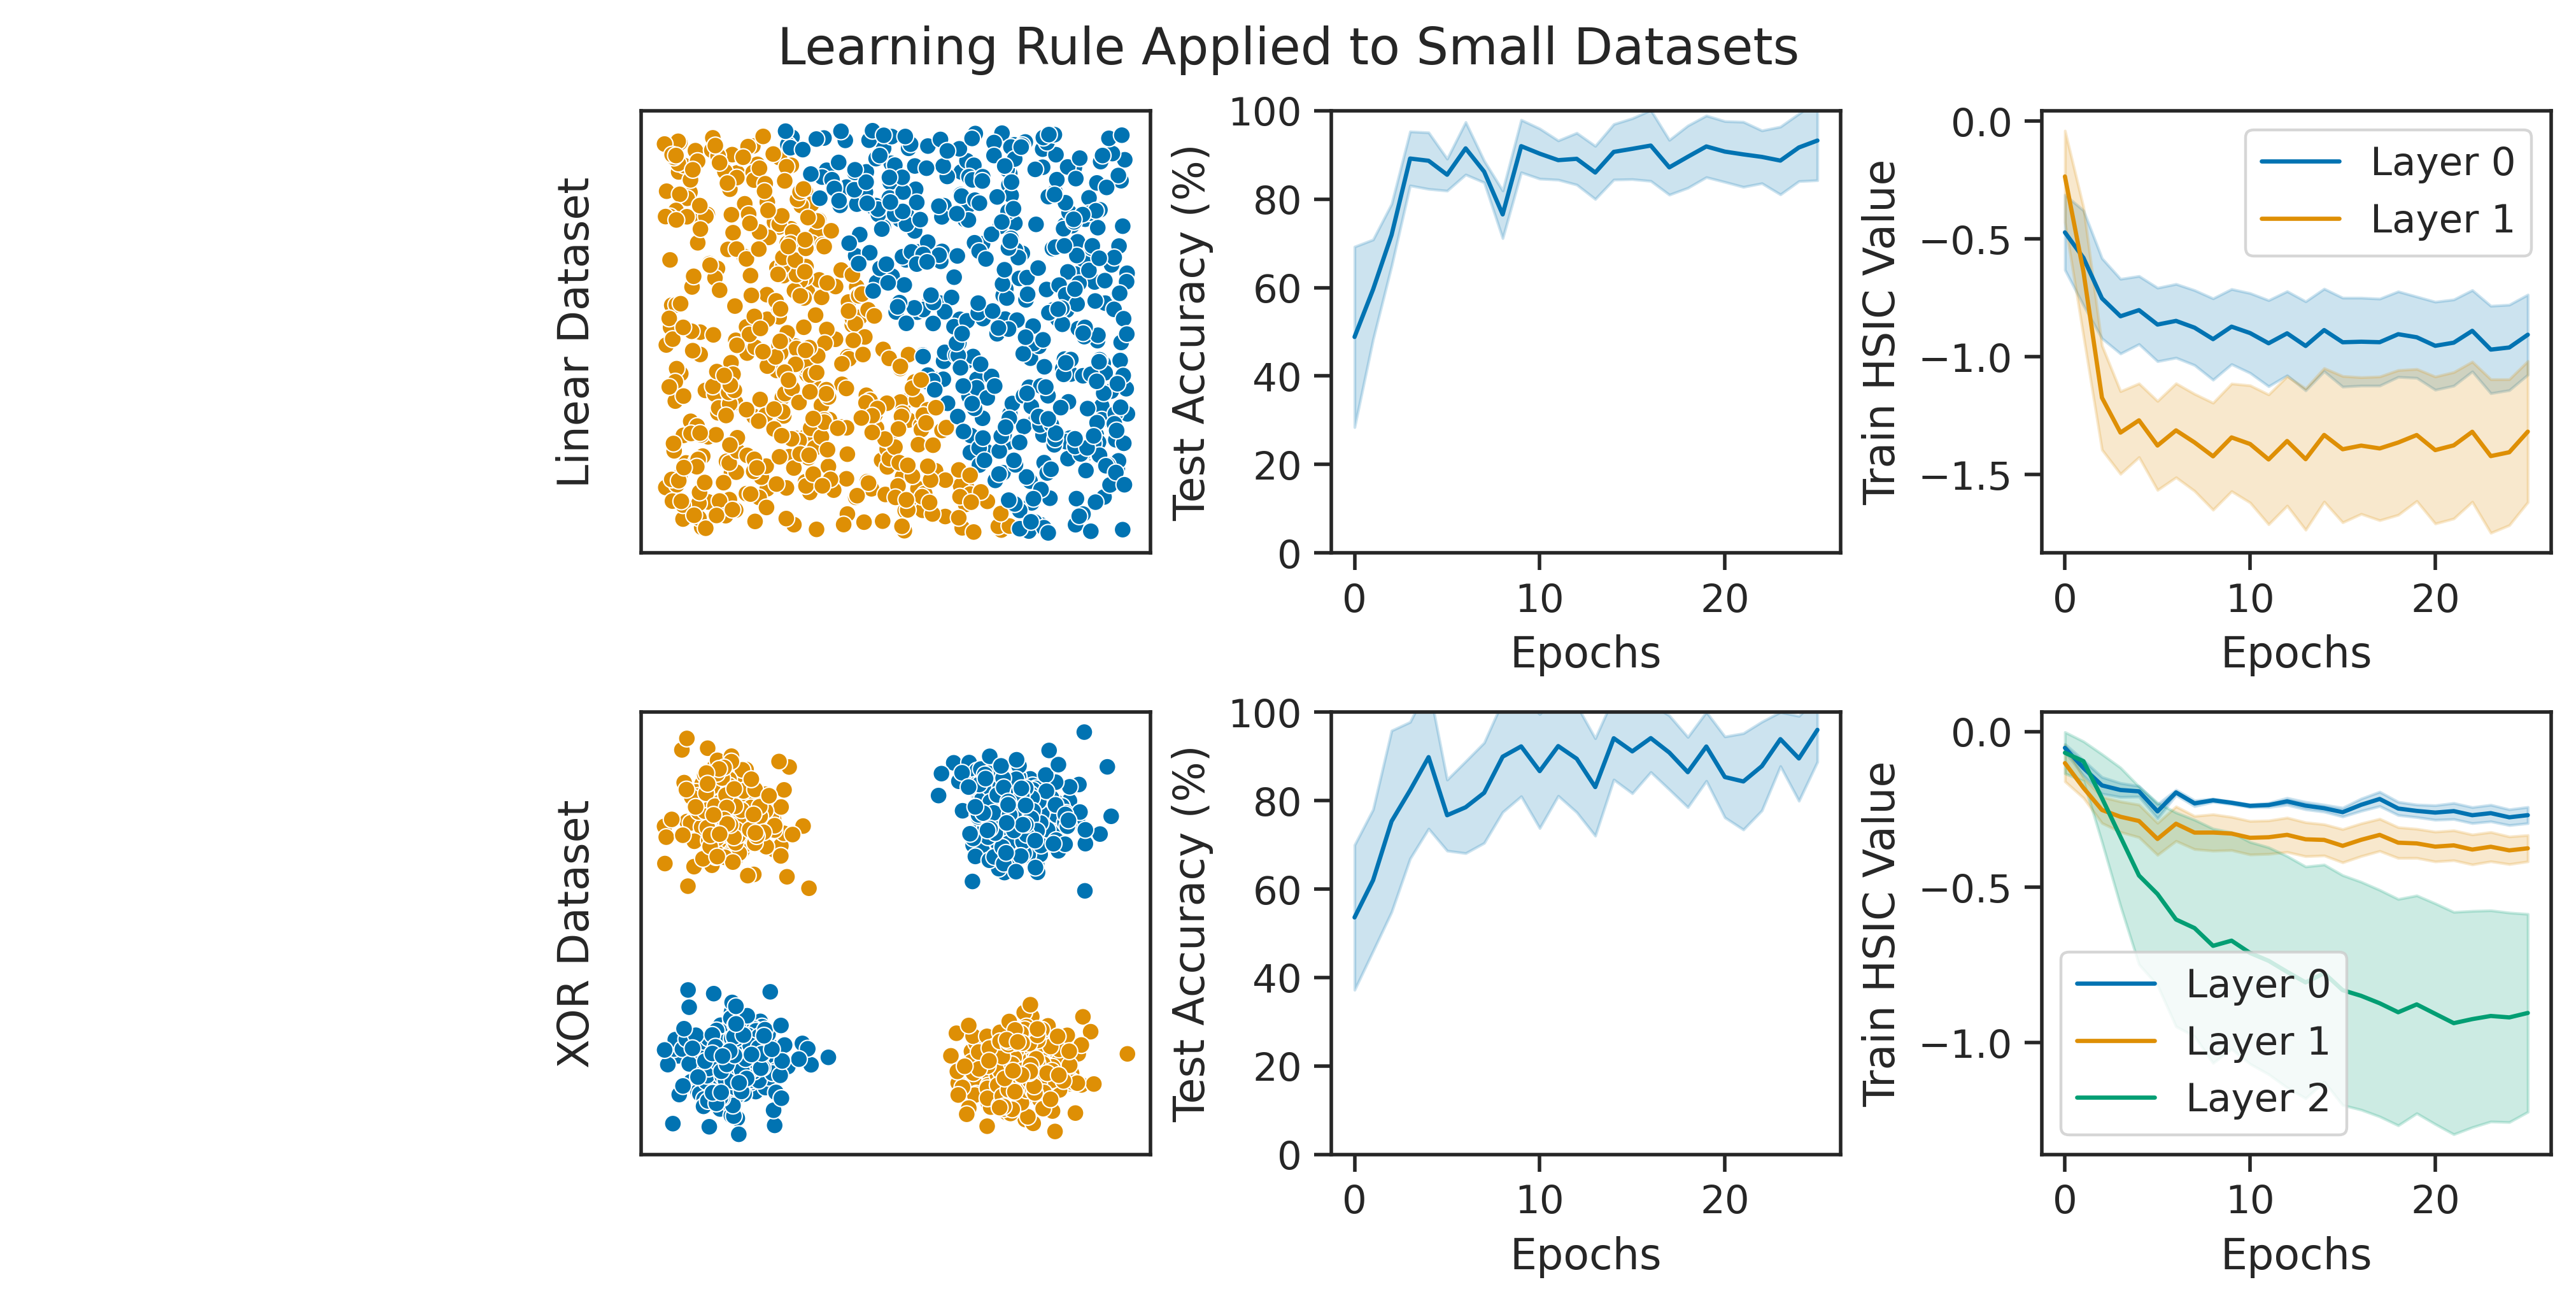

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=4, dpi=400, layout="constrained", figsize=(10, 5))
# fig.subplots_adjust(hspace=0.5, wspace=0.5)

# blank space for network diagrams
axs[0, 0].set_axis_off()
axs[1, 0].set_axis_off()

sns.scatterplot(x=linear_data["input"][:, 0],
                y=linear_data["input"][:, 1],
                hue=linear_data["label"],
                legend=False,
                ax=axs[0, 1])
axs[0, 1].tick_params(left=False, bottom=False)
axs[0, 1].set_xticklabels([])
axs[0, 1].set_yticklabels([])
axs[0, 1].set_ylabel("Linear Dataset")
sns.scatterplot(x=xor_data["input"][:, 0],
                y=xor_data["input"][:, 1],
                hue=xor_data["label"],
                legend=False,
                ax=axs[1, 1])
axs[1, 1].tick_params(left=False, bottom=False)
axs[1, 1].set_xticklabels([])
axs[1, 1].set_yticklabels([])
axs[1, 1].set_ylabel("XOR Dataset")
epochs = jnp.repeat(jnp.arange(linear_acc.shape[0]), linear_acc.shape[1])
sns.lineplot(x=epochs,
             y=jnp.reshape(linear_acc, -1),
             errorbar="sd",
             ax=axs[0, 2])
axs[0, 2].set_xlabel("Epochs")
axs[0, 2].set_ylabel("Test Accuracy (%)")
axs[0, 2].set_ylim(0, 100)
sns.lineplot(x=epochs,
             y=jnp.reshape(xor_acc, -1),
             errorbar="sd",
             ax=axs[1, 2])
axs[1, 2].set_xlabel("Epochs")
axs[1, 2].set_ylabel("Test Accuracy (%)")
axs[1, 2].set_ylim(0, 100)
for i in range(2):
    sns.lineplot(x=epochs,
                 y=jnp.reshape(linear_hsic[:, :, i], -1),
                 errorbar="sd",
                 label=f"Layer {i}",
                 ax=axs[0, 3])
axs[0, 3].set_xlabel("Epochs")
axs[0, 3].set_ylabel("Train HSIC Value")
for i in range(3):
    sns.lineplot(x=epochs,
                 y=jnp.reshape(xor_hsic[:, :, i], -1),
                 errorbar="sd",
                 label=f"Layer {i}",
                 ax=axs[1, 3])
axs[1, 3].set_xlabel("Epochs")
axs[1, 3].set_ylabel("Train HSIC Value")
fig.suptitle("Learning Rule Applied to Small Datasets")
fig.savefig("small-experiment-results.pdf", bbox_inches="tight")

# MNIST results

In [69]:
ckpt_path = "outputs/train-bp/mnist-results-2/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
mnist_bp_ckpt = mgr.restore(mgr.latest_step())

ckpt_path = "outputs/mnist-sweep/train-biohsic8/2024-01-19/19-39-31/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
mnist_hsic_ckpt = mgr.restore(mgr.latest_step())

ckpt_path = "outputs/train-bp/cifar10-results/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
cifar10_bp_ckpt = mgr.restore(mgr.latest_step())

ckpt_path = "outputs/cifar10-sweep/train-biohsic-sweep4/2024-01-20/09-18-14/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
cifar10_hsic_ckpt = mgr.restore(mgr.latest_step())

In [73]:
mnist_bp_acc = jnp.stack(mnist_bp_ckpt["metrics_history"]["test"]["accuracy"]) * 100
mnist_hsic_acc = jnp.stack(mnist_hsic_ckpt["metrics_history"]["test"]["accuracy"]) * 100
cifar10_bp_acc = jnp.stack(cifar10_bp_ckpt["metrics_history"]["test"]["accuracy"]) * 100
cifar10_bp_acc = cifar10_bp_acc[:, :15]
cifar10_hsic_acc = jnp.stack(cifar10_hsic_ckpt["metrics_history"]["test"]["accuracy"]) * 100

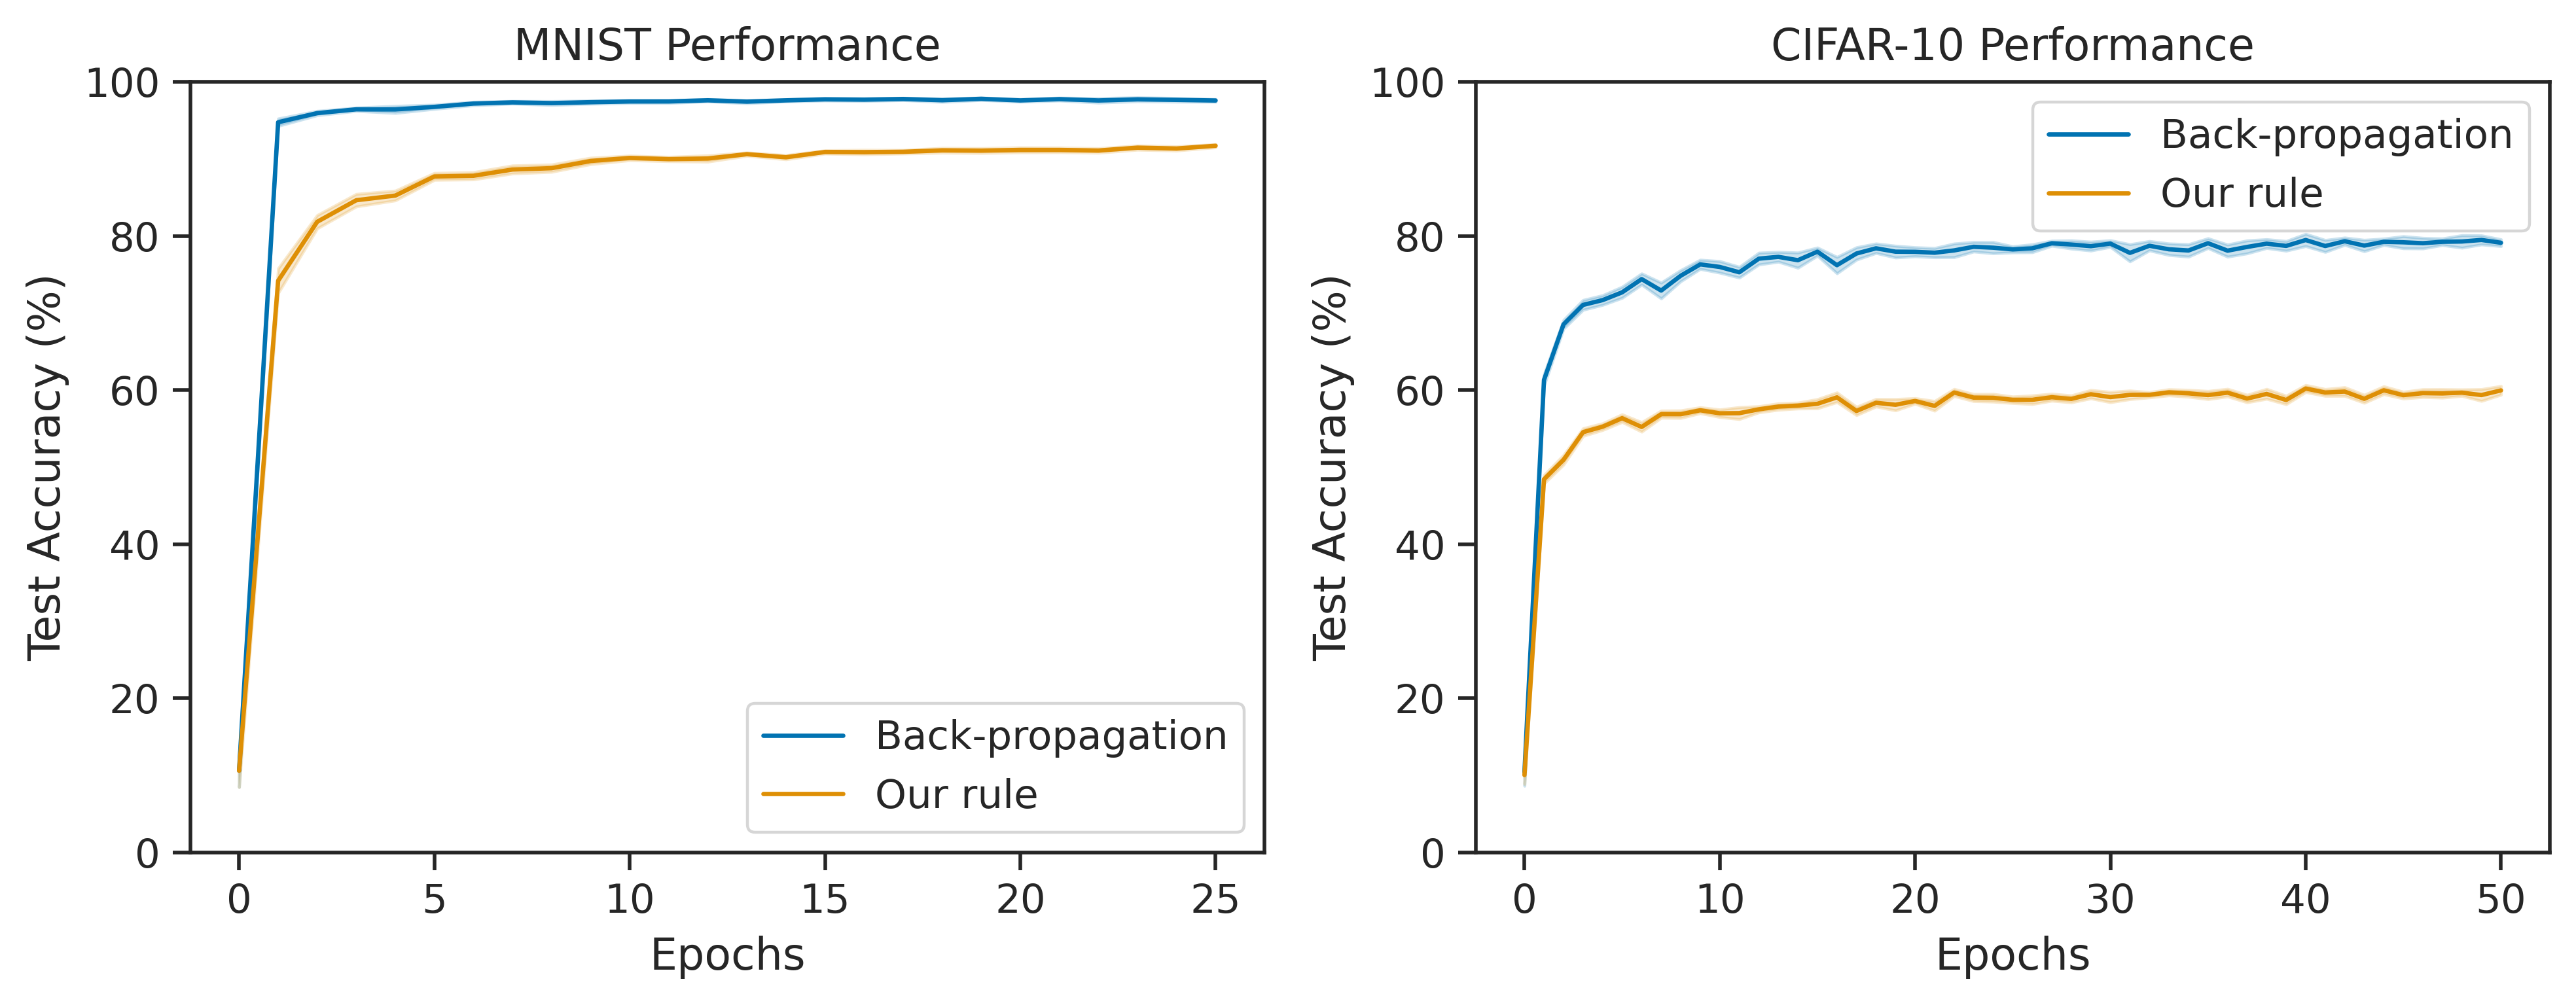

In [74]:
fig, axs = plt.subplots(ncols=2, dpi=400, figsize=(10, 4))
# fig.subplots_adjust(hspace=0.5, wspace=0.5)

epochs = jnp.repeat(jnp.arange(mnist_bp_acc.shape[0]), mnist_bp_acc.shape[1])
sns.lineplot(x=epochs,
             y=jnp.reshape(mnist_bp_acc, -1),
             errorbar="sd",
             label="Back-propagation",
             ax=axs[0])
sns.lineplot(x=epochs,
             y=jnp.reshape(mnist_hsic_acc, -1),
             errorbar="sd",
             label="Our rule",
             ax=axs[0])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Test Accuracy (%)")
axs[0].set_ylim(0, 100)
axs[0].set_title("MNIST Performance")
epochs = jnp.repeat(jnp.arange(cifar10_bp_acc.shape[0]), cifar10_bp_acc.shape[1])
sns.lineplot(x=epochs,
             y=jnp.reshape(cifar10_bp_acc, -1),
             errorbar="sd",
             label="Back-propagation",
             ax=axs[1])
sns.lineplot(x=epochs,
             y=jnp.reshape(cifar10_hsic_acc, -1),
             errorbar="sd",
             label="Our rule",
             ax=axs[1])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Test Accuracy (%)")
axs[1].set_ylim(0, 100)
axs[1].set_title("CIFAR-10 Performance")
fig.tight_layout()
fig.savefig("large-experiment-results.pdf", bbox_inches="tight")

# Memory sweep

In [83]:
# mnist_batchsizes = [2, 4, 8, 16, 32, 64, 128, 256]
# ckpt_paths = [glob(f"outputs/mnist-sweep/train-biohsic{bs}/*/*/checkpoints/")[0]
#               for bs in mnist_batchsizes]
# mgrs = [CheckpointManager(os.sep.join([os.getcwd(), p]), PyTreeCheckpointer())
#         for p in ckpt_paths]
# mnist_ckpts = [mgr.restore(mgr.latest_step()) for mgr in mgrs]

cifar10_batchsizes = [2, 4, 8, 16, 32]
ckpt_paths = [glob(f"outputs/cifar10-sweep/train-biohsic-sweep{bs}/*/*/checkpoints/")[0]
              for bs in cifar10_batchsizes]
mgrs = [CheckpointManager(os.sep.join([os.getcwd(), p]), PyTreeCheckpointer())
        for p in ckpt_paths]
cifar10_ckpts = [mgr.restore(mgr.latest_step()) for mgr in mgrs]

In [84]:
train_accs = jnp.stack([jnp.stack(ckpt["metrics_history"]["train"]["accuracy"]) * 100
                        for ckpt in cifar10_ckpts], axis=0)
test_accs = jnp.stack([jnp.stack(ckpt["metrics_history"]["test"]["accuracy"]) * 100
                        for ckpt in cifar10_ckpts], axis=0)

Text(0, 0.5, 'Test Accuracy (%)')

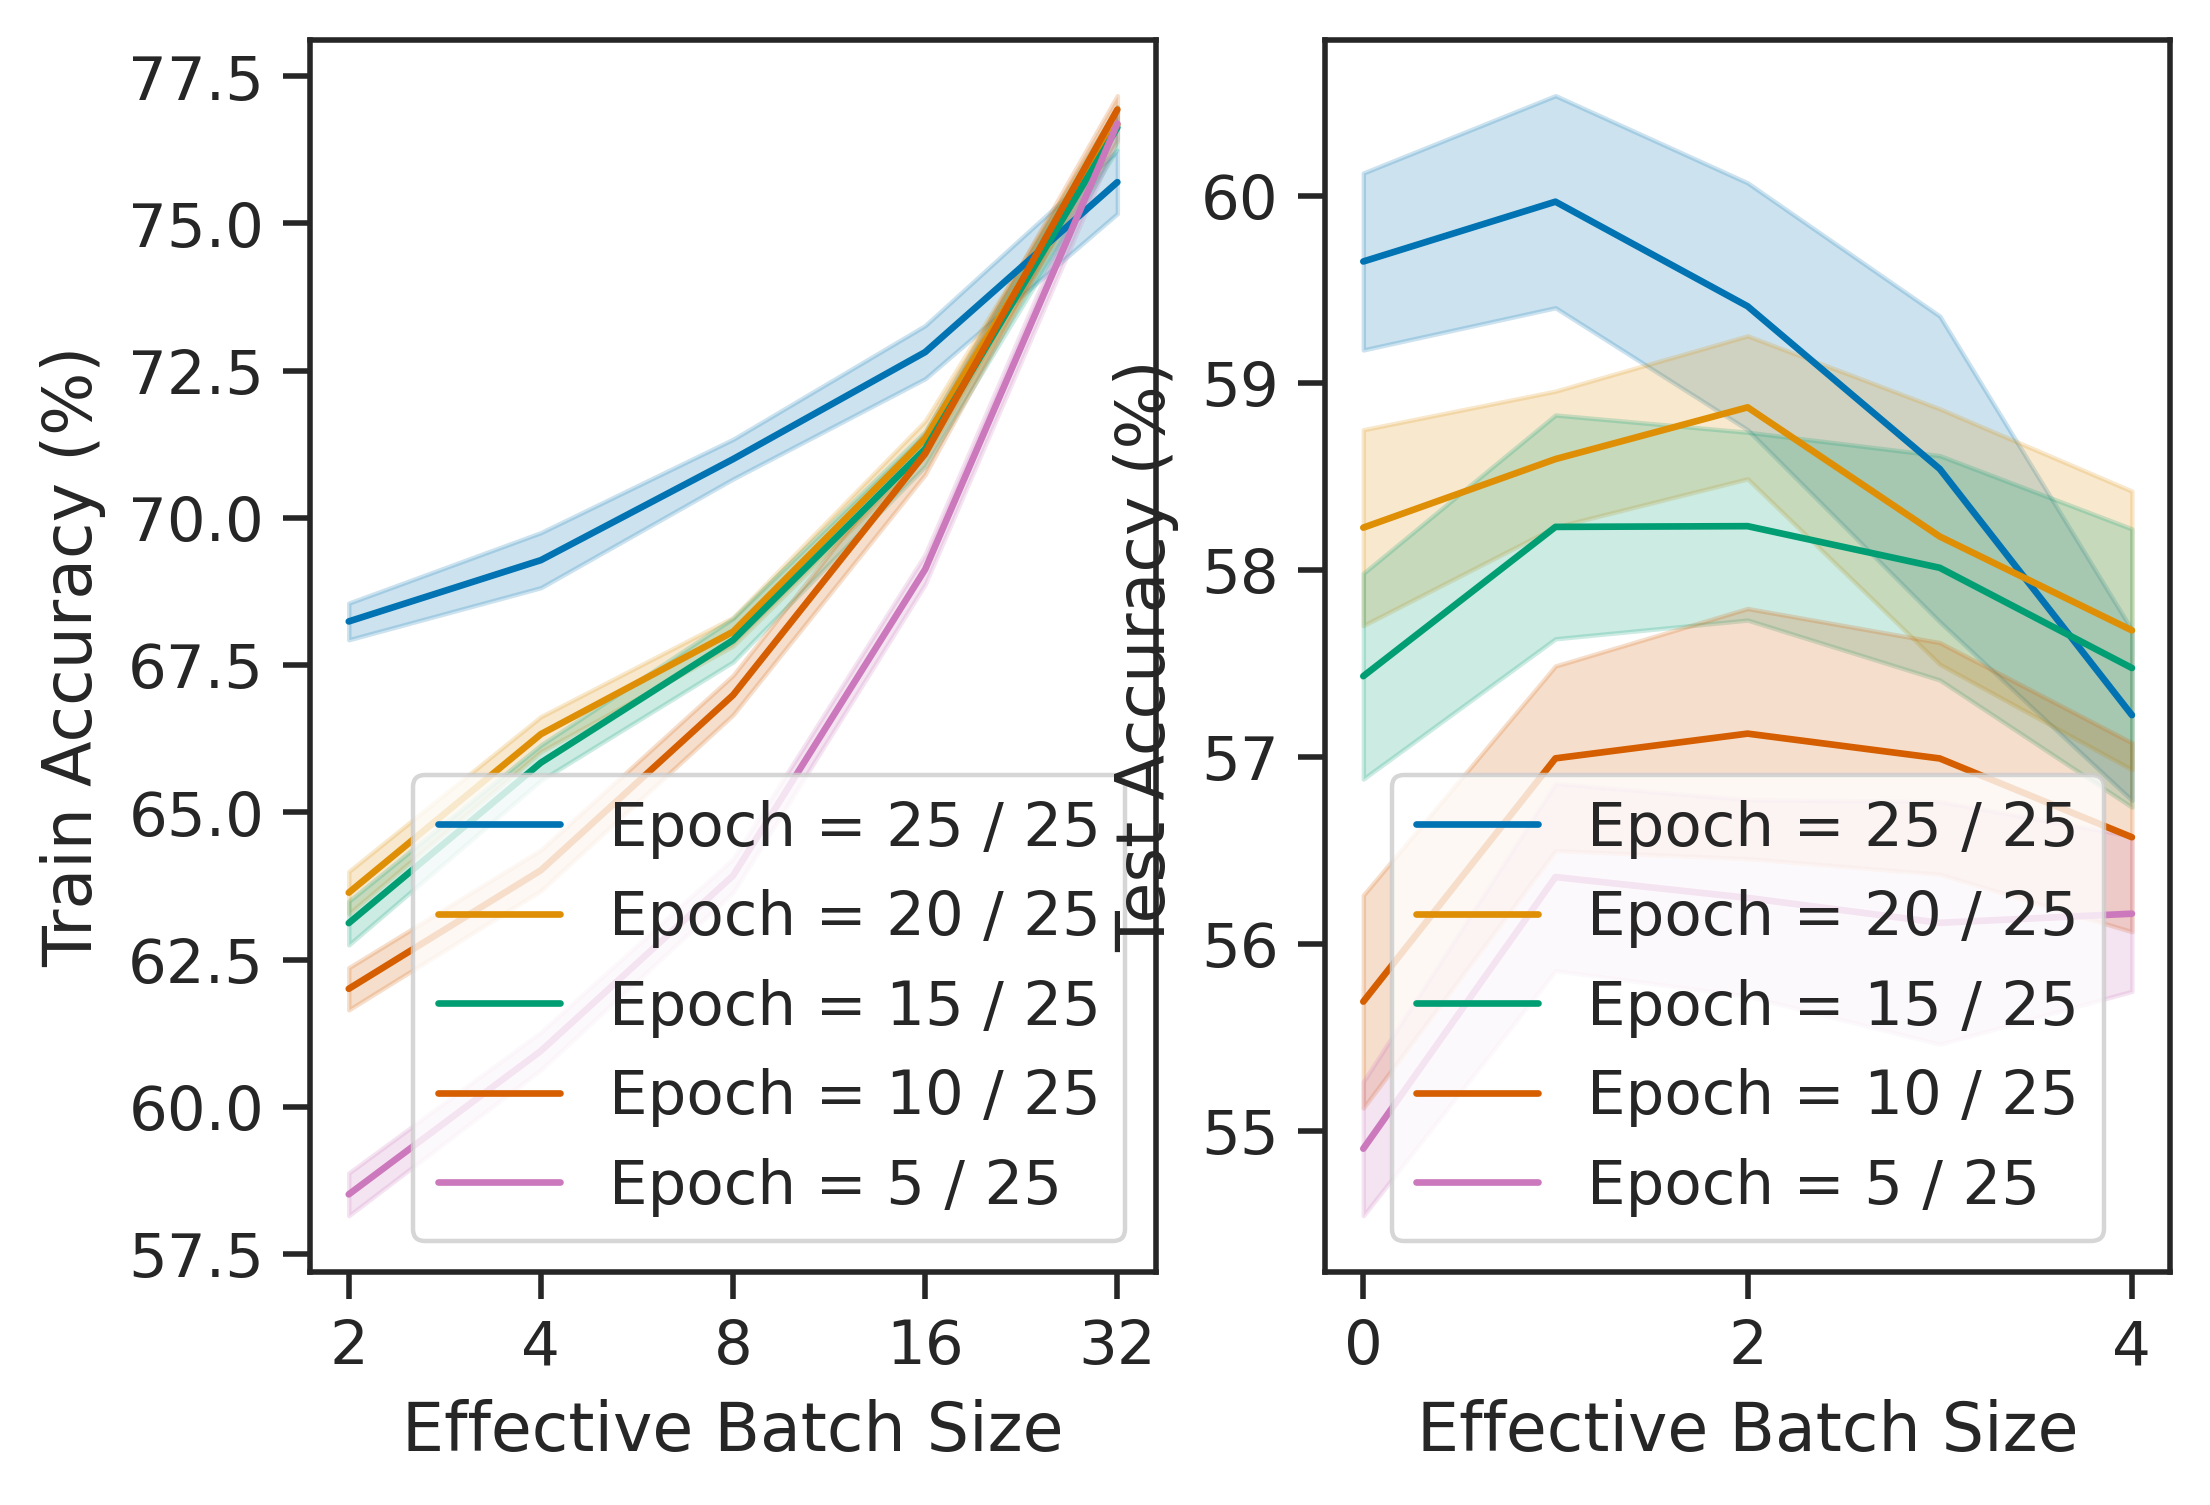

In [87]:
fig, axs = plt.subplots(ncols=2, dpi=400, figsize=(6, 4),
                        subplot_kw={"sharey": True})

# grid = jnp.transpose(jnp.mean(accs, axis=-1))[::-1, :]
# sns.heatmap(grid[1:, :], cmap="viridis", ax=axs)
# axs.set_xticks(jnp.arange(len(batchsizes)) + 0.5, batchsizes)
xs = jnp.repeat(jnp.arange(len(cifar10_batchsizes)), train_accs.shape[-1])
sns.lineplot(x=xs, y=jnp.reshape(train_accs[:, -1, :], -1),
            label="Epoch = 25 / 25", errorbar="sd", ax=axs[0])
sns.lineplot(x=xs, y=jnp.reshape(train_accs[:, 20, :], -1),
            label="Epoch = 20 / 25", errorbar="sd", ax=axs[0])
sns.lineplot(x=xs, y=jnp.reshape(train_accs[:, 15, :], -1),
            label="Epoch = 15 / 25", errorbar="sd", ax=axs[0])
sns.lineplot(x=xs, y=jnp.reshape(train_accs[:, 10, :], -1),
            label="Epoch = 10 / 25", errorbar="sd", ax=axs[0])
sns.lineplot(x=xs, y=jnp.reshape(train_accs[:, 5, :], -1),
            label="Epoch = 5 / 25", errorbar="sd", ax=axs[0])
axs[0].set_xticks(jnp.arange(len(cifar10_batchsizes)), cifar10_batchsizes)
axs[0].set_xlabel("Effective Batch Size")
axs[0].set_ylabel("Train Accuracy (%)")
sns.lineplot(x=xs, y=jnp.reshape(test_accs[:, -1, :], -1),
            label="Epoch = 25 / 25", errorbar="sd", ax=axs[1])
sns.lineplot(x=xs, y=jnp.reshape(test_accs[:, 20, :], -1),
            label="Epoch = 20 / 25", errorbar="sd", ax=axs[1])
sns.lineplot(x=xs, y=jnp.reshape(test_accs[:, 15, :], -1),
            label="Epoch = 15 / 25", errorbar="sd", ax=axs[1])
sns.lineplot(x=xs, y=jnp.reshape(test_accs[:, 10, :], -1),
            label="Epoch = 10 / 25", errorbar="sd", ax=axs[1])
sns.lineplot(x=xs, y=jnp.reshape(test_accs[:, 5, :], -1),
            label="Epoch = 5 / 25", errorbar="sd", ax=axs[1])
axs[0].set_xticks(jnp.arange(len(cifar10_batchsizes)), cifar10_batchsizes)
axs[1].set_xlabel("Effective Batch Size")
axs[1].set_ylabel("Test Accuracy (%)")
# axs.set_title("MNIST Performance for Varying Effective Batch Sizes")
# fig.savefig("mnist_memory_sweep.pdf", bbox_inches="tight")